##### Let's evaluate and visualize the performance of the trained denoising model on test data, providing both quantitative metrics (SSIM scores) and visual comparisons between low-count, denoised, and high-count images.

#### Initial Setup
Let's start by importing the necessary libraries and directories for data handling, model building, training, and evaluation. We will use the `pandas`, `numpy`, `matplotlib`, `h5py`, and `keras` libraries.

In [1]:
#!/usr/bin/env python3
import os
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

output_dir = '/home/nnds0a/Presentation/output/trained_model'  # Output directory containing model checkpoints
test_data_path = '/home/nnds0a/Presentation/data/test_data.hdf5'  # Path to the HDF5 test data file



2024-07-24 00:19:31.990655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 00:19:31.990686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 00:19:31.990714: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 00:19:31.997748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Custom Loss Functions:
The combined_loss and ssim_loss functions ensure that the models trained achieve a balance between pixel-wise accuracy and structural similarity, as discussed in the thesis.


In [2]:
# Define custom loss functions
def combined_loss(y_true, y_pred):
    """Combine Mean Absolute Error and Structural Similarity Index Loss
    This function computes a loss that is a combination of MAE and SSIM loss.
    
    Parameters:
    y_true: Tensor of true values.
    y_pred: Tensor of predicted values.
    
    Returns:
    Combined loss value.
    """
    return tf.reduce_mean(tf.abs(y_true - y_pred)) + ssim_loss(y_true, y_pred)

def ssim_loss(y_true, y_pred):
    """Structural Similarity Index Loss
    This function computes the SSIM loss between true and predicted values.
    
    Parameters:
    y_true: Tensor of true values.
    y_pred: Tensor of predicted values.
    
    Returns:
    SSIM loss value.
    """
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

### Model Building:

The build_model function uses the IRUNet architecture defined in models.py, aligning with the thesis’s use of this specific deep learning model for denoising.

In [3]:

# Function to build the model
def build_model(input_shape=(192, 240, 1)):
    """Builds the IRUNet model architecture
    This function imports and builds the IRUNet model architecture.
    
    Parameters:
    input_shape: Shape of the input data (default is (192, 240, 1)).
    
    Returns:
    IRUNet model.
    """
    from models import IRUNet  # Import the model architecture function
    return IRUNet(input_shape=input_shape)


#### Model Loading:

The load_best_model function ensures that the evaluation is performed on the most accurate model by selecting the best checkpoint based on the lowest loss. This reflects the thesis's emphasis on reliable and accurate denoising.

In [4]:

# Function to load the best model checkpoint
def load_best_model(output_dir):
    """Load the model checkpoint with the lowest loss
    This function scans the specified directory for model checkpoints and loads the one with the lowest loss.
    
    Parameters:
    output_dir: Directory containing model checkpoints.
    
    Returns:
    The model with the best (lowest) loss.
    """
    best_model_path = None
    best_loss = float('inf')
    
    # Scan the output directory for model checkpoints
    for filename in os.listdir(output_dir):
        if filename.endswith('.hdf5'):
            model_path = os.path.join(output_dir, filename)
            try:
                model_loss = float(filename.split('=')[1].split('.hdf5')[0])
                if model_loss < best_loss:
                    best_loss = model_loss
                    best_model_path = model_path
            except ValueError:
                print(f"Skipping invalid model file: {model_path}")
    
    # Raise an error if no valid model is found
    if not best_model_path:
        raise FileNotFoundError("No valid Keras model found in the specified directory.")
    
    # Build the model and load the weights
    model = build_model()
    model.load_weights(best_model_path)
    return model

model = load_best_model(output_dir)  # Load the best model checkpoint


2024-07-24 00:19:33.465123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 00:19:33.469948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 00:19:33.470127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

#### Data Handling:

The load_test_data function processes the test data to match the model's input requirements, ensuring that the data used for evaluation is consistent with the data used during training, as described in the thesis.

In [5]:

# Function to load the test data from HDF5 file
def load_test_data(test_data_path):
    """Load and preprocess test data from HDF5 file
    This function loads low-count and high-count test data from an HDF5 file and preprocesses it to match the model's input shape.
    
    Parameters:
    test_data_path: Path to the HDF5 test data file.
    
    Returns:
    lc_test: Preprocessed low-count test data.
    hc_test: Preprocessed high-count test data.
    """
    with h5py.File(test_data_path, 'r') as f:
        lc_test = f['low_count/data'][:]  # Load low-count test data
        hc_test = f['high_count/data'][:]  # Load high-count test data
    
    # Transpose and expand dimensions to match the model input shape
    lc_test = lc_test.transpose((2, 0, 1))
    lc_test = np.expand_dims(lc_test, axis=-1)
    hc_test = hc_test.transpose((2, 0, 1))
    hc_test = np.expand_dims(hc_test, axis=-1)
    
    return lc_test, hc_test

lc_test, hc_test = load_test_data(test_data_path)  # Load the test data


#### Model Evaluation:

The evaluate_model function uses SSIM to evaluate the model's performance, providing a quantitative measure of how well the model denoises the data. This aligns with the thesis's requirement for accurate evaluation metrics.

In [6]:
# Function to evaluate the model on the test data
def evaluate_model(model, lc_data, hc_data):
    """Evaluate the model on test data
    This function evaluates the model's performance on the test data using SSIM as the evaluation metric.
    
    Parameters:
    model: Trained model to be evaluated.
    lc_data: Low-count test data.
    hc_data: High-count test data.
    
    Returns:
    Prints the mean SSIM score of the model on the test data.
    """
    predictions = model.predict(lc_data)
    ssim_scores = [tf.image.ssim(predictions[i], hc_data[i], max_val=1.0).numpy() for i in range(len(lc_data))]
    print(f'Mean SSIM Score: {np.mean(ssim_scores)}')
    
evaluate_model(model, lc_test, hc_test)  # Evaluate the model on the test data

2024-07-24 00:19:36.001112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2024-07-24 00:19:36.098173: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-07-24 00:19:36.098204: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-07-24 00:19:36.098323: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-07-24 00:19:36.748815: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


 3/95 [..............................] - ETA: 5s  

2024-07-24 00:19:38.725256: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


95/95 [==============================] - 16s 133ms/step


2024-07-24 00:19:51.719321: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-07-24 00:19:51.819351: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-07-24 00:19:51.820440: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-07-24 00:19:51.822236: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-07-24 00:19:51.822256: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-07-24

Mean SSIM Score: 1.1340226387397527e-15


Visualization:

The visualize_results function provides a visual comparison of low-count, denoised, and high-count images, which is crucial for demonstrating the effectiveness of the denoising process in a manner that is easy to interpret. This supports the thesis's claims about the visual and quantitative improvements achieved through the proposed methods.

1/1 [==============================] - 1s 514ms/step


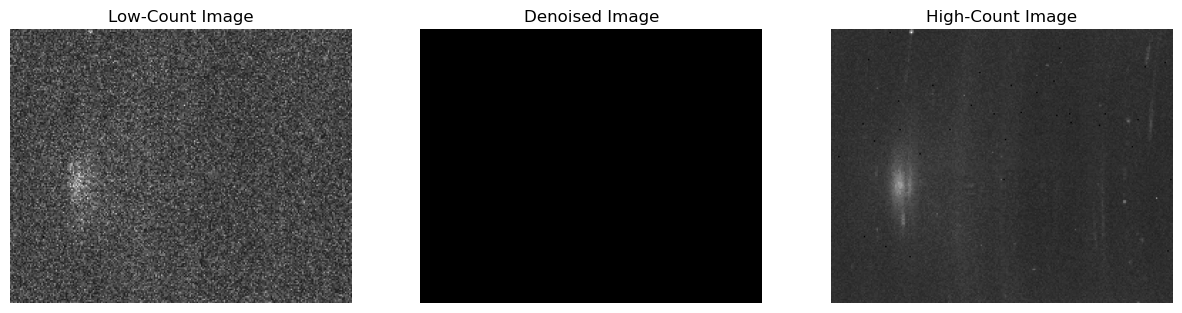

In [7]:

# Function to visualize the results
def visualize_results(model, lc_data, hc_data, index=0):
    """Visualize low-count, denoised, and high-count images
    This function visualizes a low-count image, its denoised version (predicted by the model), and the corresponding high-count image.
    
    Parameters:
    model: Trained model to be used for prediction.
    lc_data: Low-count test data.
    hc_data: High-count test data.
    index: Index of the test sample to be visualized (default is 0).
    
    Returns:
    Displays the images using matplotlib.
    """
    prediction = model.predict(np.expand_dims(lc_data[index], axis=0))[0]
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Low-Count Image')
    plt.imshow(lc_data[index].squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Denoised Image')
    plt.imshow(prediction.squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('High-Count Image')
    plt.imshow(hc_data[index].squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.show()

# Visualize the first test sample
visualize_results(model, lc_test, hc_test, index=0)  

